# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [1]:
# The dataset represent 17 campaigns that occurred between May 2008 and November 2010.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
# Import libraries
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

#import warnings
#warnings.filterwarnings('ignore')

In [3]:
# Load dataset
bank_df = pd.read_csv('data/bank-additional-full.csv', sep=';')

### Problem 3: Understanding the Features

Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.

```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```


In [4]:
# Examine first 5 rows
bank_df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
# Count NA values to identify missing data
bank_df.isna().sum()[lambda x: x > 0]

Series([], dtype: int64)

In [6]:
# Examine dataset structure to identify possible changes needed in datatypes
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [7]:
# Examine descriptive statistics to identify numeric ranges
bank_df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [8]:
# Observing numeric ranges from descriptive statistics, we can downcast numeric columns to reduce memory usage
int_cols = bank_df.select_dtypes(include=['int64']).columns.tolist()
bank_df[int_cols] = bank_df[int_cols].apply(pd.to_numeric, downcast='integer')

# Also, we can convert object columns to category type to reduce memory usage
object_cols = bank_df.select_dtypes(include=['object']).columns.tolist()
bank_df[object_cols] = bank_df[object_cols].astype("category")

In [9]:
# Convert target variable to numeric
bank_df.replace({'y': {'no': 0, 'yes': 1}, }, inplace=True)
bank_df['y'] = bank_df['y'].astype('int8')

In [10]:
# Drop duplicate rows
bank_df.drop_duplicates(keep=False, inplace=True)

In [11]:
# Verify new dataset structure and memory usage
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41164 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41164 non-null  int8    
 1   job             41164 non-null  category
 2   marital         41164 non-null  category
 3   education       41164 non-null  category
 4   default         41164 non-null  category
 5   housing         41164 non-null  category
 6   loan            41164 non-null  category
 7   contact         41164 non-null  category
 8   month           41164 non-null  category
 9   day_of_week     41164 non-null  category
 10  duration        41164 non-null  int16   
 11  campaign        41164 non-null  int8    
 12  pdays           41164 non-null  int16   
 13  previous        41164 non-null  int8    
 14  poutcome        41164 non-null  category
 15  emp.var.rate    41164 non-null  float64 
 16  cons.price.idx  41164 non-null  float64 
 17  cons.conf.id

[Text(0, 0, '36526 (89%)'), Text(0, 0, '4638 (11%)')]

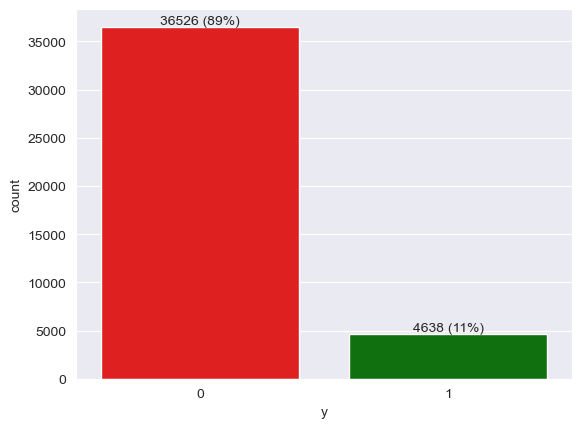

In [12]:
# Examine target variable
colors = ['red', 'green']

ax = sns.countplot(
    x=bank_df['y'],
    order=bank_df['y'].value_counts(ascending=False).index,
    palette=colors,
)

abs_values = bank_df['y'].value_counts(ascending=False)
rel_values = bank_df['y'].value_counts(ascending=False, normalize=True).values * 100
labels = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]
ax.bar_label(container=ax.containers[0], labels=labels)

This is an imbalanced class, this will be addressed by either up sample the minority class or down sample the majority class
Also, some models are more sensible to imbalanced classes than others, this will be evaluated during model comparison.

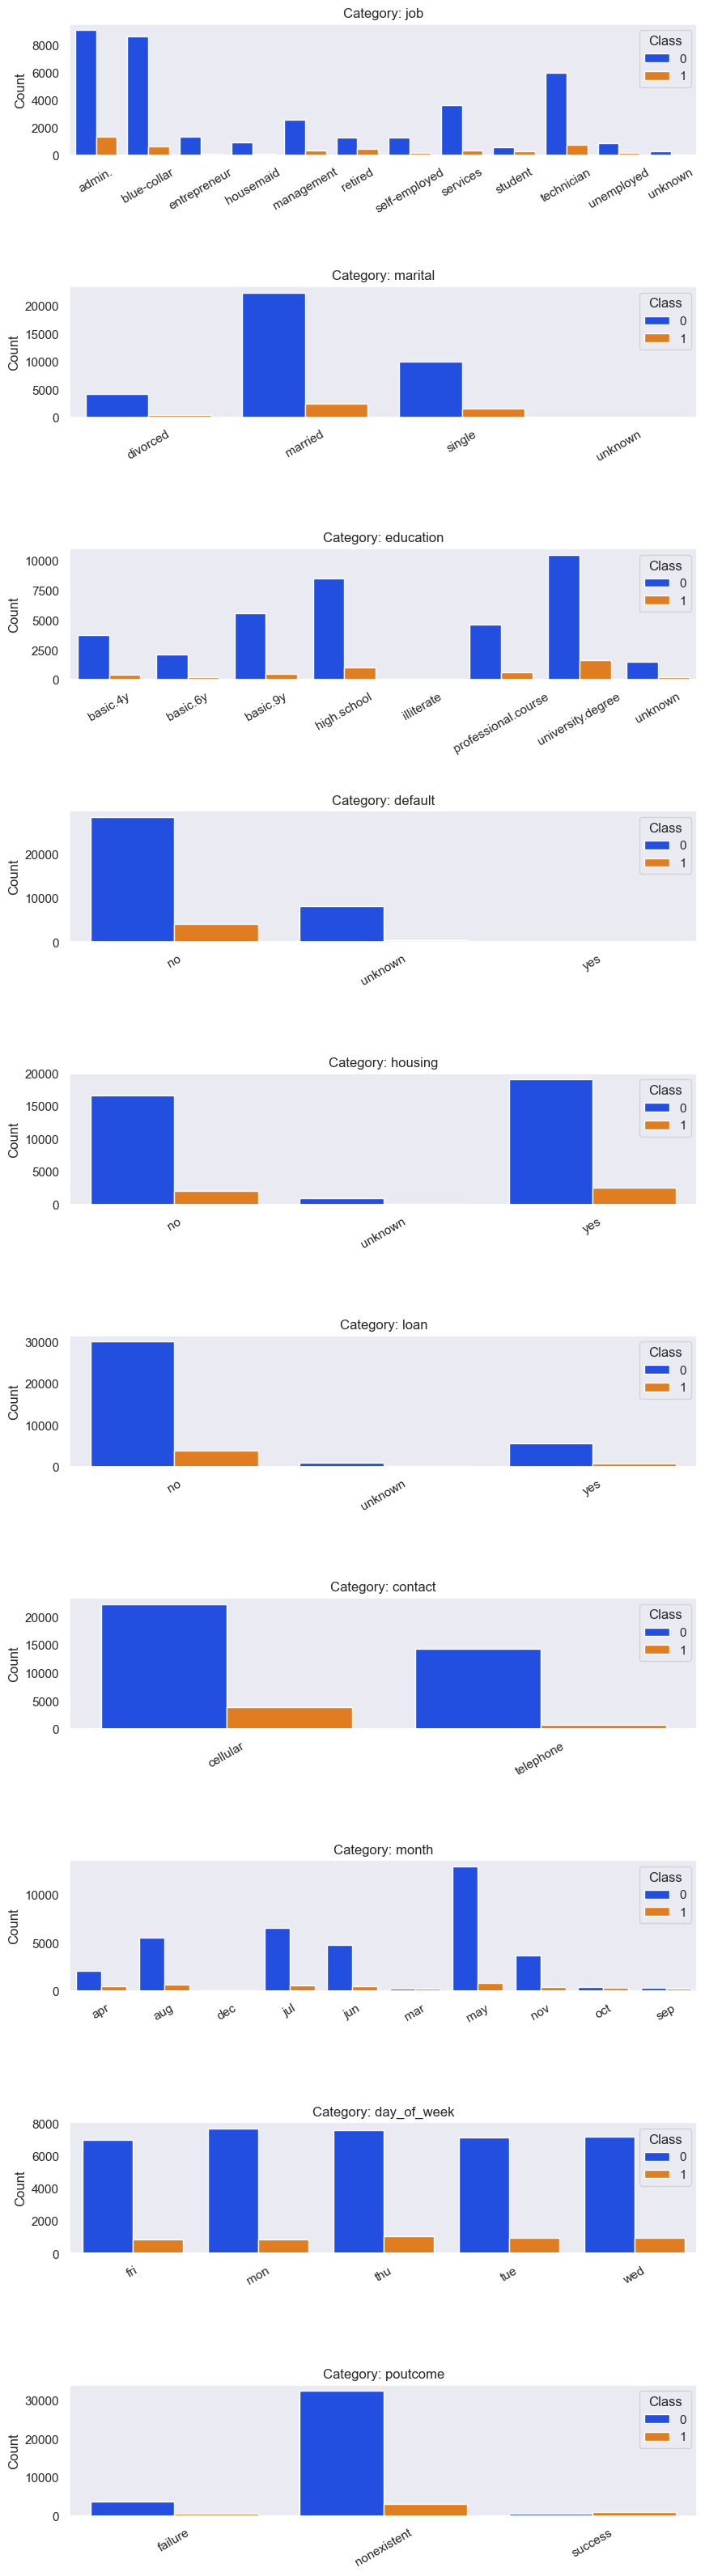

In [13]:
# Create count plots to examine categories
sns.set_theme(style='dark', palette='bright')

fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 40))
fig.subplots_adjust(hspace=1, wspace=1)

i = 0
for col in bank_df.columns:
    if bank_df[col].dtype == 'category':
        sns.countplot(
            data=bank_df,
            x=col, hue='y', ax=axes[i],
        )
        axes[i].set_title('Category: ' + col)
        axes[i].set_ylabel('Count')
        axes[i].set_xlabel('')
        axes[i].tick_params(axis='x', labelrotation=30)
        axes[i].legend(title='Class')
        i = i + 1

plt.show()

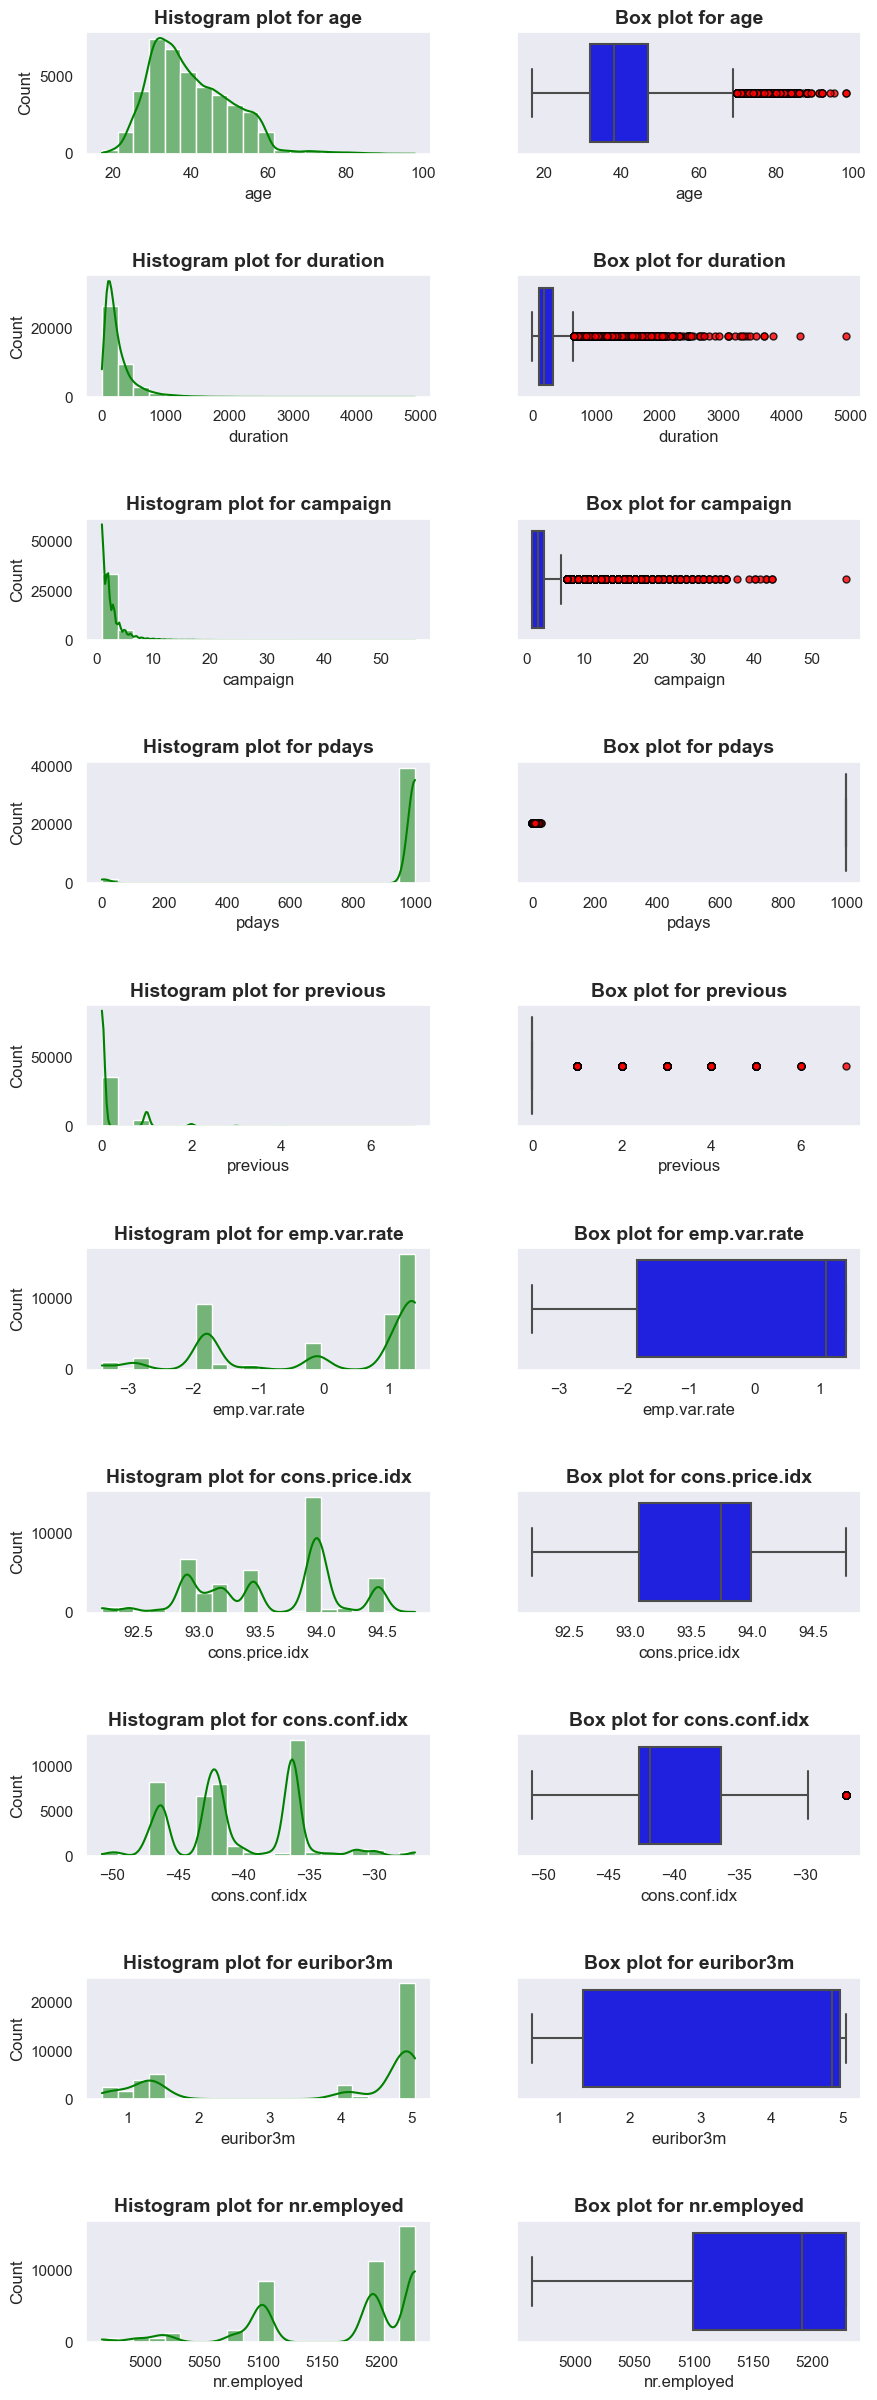

In [14]:
# Create histograms and box plots for numeric columns to inspect their distribution and possible outliers.
sns.set_theme(style='dark', palette='bright')

fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 30))
fig.subplots_adjust(hspace=1, wspace=0.25)

flier_props = dict(marker='o', markersize=5, markeredgecolor='black', markerfacecolor='red', alpha=0.8)

i = 0
for col in bank_df.columns:
    if bank_df[col].dtype != 'category' and col != 'y':
        sns.histplot(
            data=bank_df, x=col, bins=20, kde=True,
            ax=axes[i, 0],
            color='green')
        axes[i, 0].set_title('Histogram plot for ' + col, fontsize=14, fontweight='bold')
        sns.boxplot(
            data=bank_df, x=col,
            ax=axes[i, 1],
            color='blue', flierprops=flier_props,
        )
        axes[i, 1].set_title('Box plot for ' + col, fontsize=14, fontweight='bold')
        i = i + 1

plt.show()

Age, Duration and Campaign columns present outliers, some models are more sensitive to outliers than others.
This may present an issue that will be evaluated and addressed during model improvement phase.
However, we won't include duration in the models since our goal is to build a realistic estimator.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [15]:
# The business goal is to find a model that can explain success of a contact, i.e. if the client subscribes the deposit.
# Such model can increase campaign efficiency by identifying the main characteristics that affect success,
# helping in a better management of the available resources and better selection of potential buying customers.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [16]:
# Select initial set of features
initial_features = [
    # bank client data
    'age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
]

In [17]:
# Display class counts before resampling
bank_df.y.value_counts()

0    36526
1     4638
Name: y, dtype: int64

In [18]:
# Separate majority and minority classes
majority_df = bank_df[bank_df.y == 0]
minority_df = bank_df[bank_df.y == 1]

#minority_upsampled_df = resample(minority_df, replace=True, n_samples=36526, random_state=123)  # Up sample minority class
#bank_df = pd.concat([majority_df, minority_upsampled_df])  # Combine majority class with up sampled minority class

majority_downsampled_df = resample(majority_df, replace=False, n_samples=4638,
                                   random_state=123)  # Down sample majority class
bank_df = pd.concat([majority_downsampled_df, minority_df])  # Combine minority class with down sampled majority class

# Display new class counts
bank_df.y.value_counts()

0    4638
1    4638
Name: y, dtype: int64

In [19]:
# Define preprocessing pipeline to scale numeric columns and apply one-hot encoding to categorical columns
standard_scaler = StandardScaler()
onehot_encoder = OneHotEncoder(handle_unknown='ignore')

numeric_preprocessor = Pipeline(
    steps=[
        ('scale', standard_scaler),
    ],
)

categorical_preprocessor = Pipeline(
    steps=[
        ('encode', onehot_encoder),
    ],
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_preprocessor, make_column_selector(dtype_exclude='category')),
        ("categorical", categorical_preprocessor, make_column_selector(dtype_include='category')),
    ],
    verbose_feature_names_out=False,
    sparse_threshold=0,
    verbose=True
)

In [20]:
# Apply preprocessing pipeline
#bank_df = bank_df.sample(3000)

bank_df1 = bank_df.copy()
X = bank_df1[initial_features]
y = bank_df1['y']

trans = preprocessor.fit_transform(X)
preprocessor.get_feature_names_out()
X_trans = pd.DataFrame(trans, columns=preprocessor.get_feature_names_out())

[ColumnTransformer] ....... (1 of 2) Processing numeric, total=   0.0s
[ColumnTransformer] ... (2 of 2) Processing categorical, total=   0.0s


In [21]:
X_trans.head()

,age,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,education_university.degree,education_unknown,default_no,default_unknown,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes
0,-0.277653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.306325,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-0.194227,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,-0.778205,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,-0.611354,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [22]:
# Split bank dataset into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.25, random_state=42)

In [23]:
X_train.head()

,age,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,education_university.degree,education_unknown,default_no,default_unknown,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes
7075,-0.361078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5325,1.307429,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
6945,0.806877,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4058,-1.362182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4453,0.222899,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [24]:
# This classifier serves as a simple baseline to compare against other more complex classifiers
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
dummy_clf.predict(X_test)

baseline_score = dummy_clf.score(X_test, y_test)
print(f'Baseline score: {baseline_score.round(2)}')

Baseline score: 0.5


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [25]:
# Define estimator pipeline for a basic model
lr_model = LogisticRegression(max_iter=10000)

lr_pipe = Pipeline(
    steps=[
        #('transform', preprocessor),
        ('model', lr_model)
    ],
)

In [26]:
# Train the model
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('model', LogisticRegression(max_iter=10000))])

### Problem 9: Score the Model

What is the accuracy of your model?

In [27]:
# Examine initial score for a basic model
y_pred = lr_pipe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy Score: {accuracy: .2f}')

Test Accuracy Score:  0.59


In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.56      0.58      1162
           1       0.58      0.62      0.60      1157

    accuracy                           0.59      2319
   macro avg       0.59      0.59      0.59      2319
weighted avg       0.59      0.59      0.59      2319



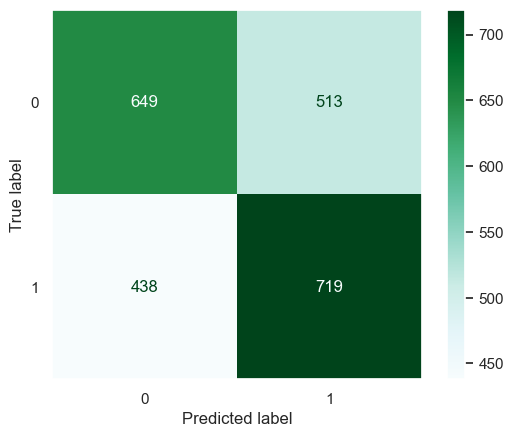

In [29]:
# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.BuGn)

In [30]:
# Display ROC and Precision-Recall Curves for better understanding
y_score = lr_pipe.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=lr_pipe.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='Logistic Regression')

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=lr_pipe.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall, estimator_name='Logistic Regression')

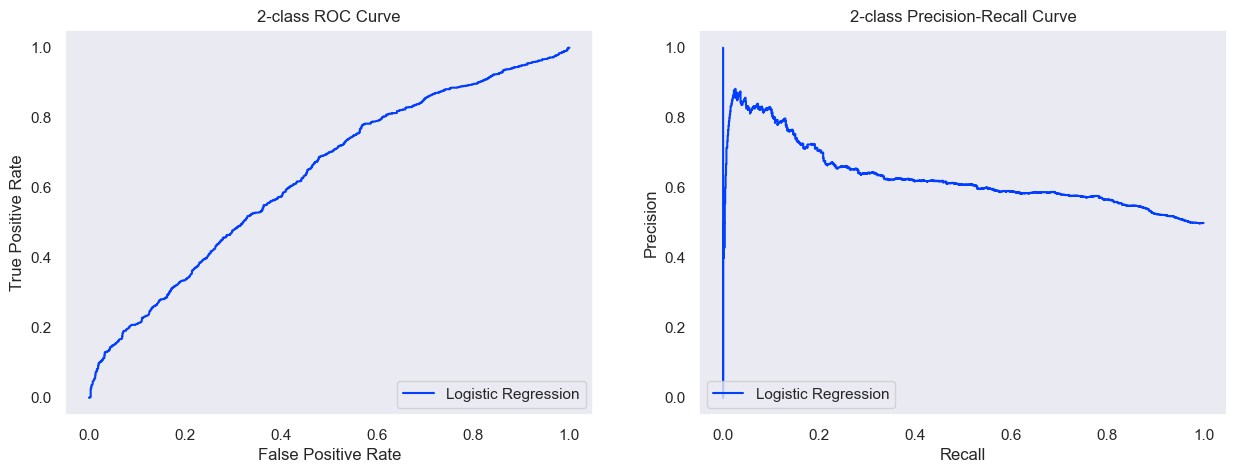

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

roc_display.plot(ax=ax1)
roc_display.ax_.set_title('2-class ROC Curve')

pr_display.plot(ax=ax2)
pr_display.ax_.set_title('2-class Precision-Recall Curve')

plt.show()

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [32]:
# Define dataframe to store results for different models
model_results = pd.DataFrame(columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])

In [33]:
# Create list of models for evaluation and comparison
names = [
    'K-Nearest Neighbors',
    'Logistic Regression',
    'Decision Tree',
    'Support Vector Machine',
]

classifiers = [
    KNeighborsClassifier(),
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(),
    SVC(),
]

In [34]:
# Train and score models
i = 0
for name, clf in zip(names, classifiers):
    begin = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    total = round(end - begin, 3)
    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)
    print(f'{name} completed in {total}s, train={score_train.round(2)}, test={score_test.round(2)}')
    y_train_pred = clf.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    y_test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    new_row = pd.DataFrame(
        {
            'Model': name,
            'Train Time': total,
            'Train Accuracy': train_accuracy.round(2),
            'Test Accuracy': test_accuracy.round(2),
        },
        index=[i]
    )
    i = i + 1
    model_results = pd.concat([model_results, new_row])

K-Nearest Neighbors completed in 0.0s, train=0.71, test=0.59
Logistic Regression completed in 0.079s, train=0.61, test=0.59
Decision Tree completed in 0.05s, train=0.85, test=0.57
Support Vector Machine completed in 4.544s, train=0.64, test=0.6


In [35]:
# Display model scores
model_results

,Model,Train Time,Train Accuracy,Test Accuracy
0,K-Nearest Neighbors,0.000,0.71,0.59
1,Logistic Regression,0.079,0.61,0.59
2,Decision Tree,0.050,0.85,0.57
3,Support Vector Machine,4.544,0.64,0.60


In [36]:
# From the results, we can conclude the following:
# So far, all the models are performing poorly, especially on the test dataset.
# Decision tree is over fitting the training dataset and therefore having the worst performance on the test dataset from all models.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [37]:
# Create a dataset copy for model improvement
bank_df2 = bank_df.copy()

In [38]:
# Removing outliers from age column
bank_df2 = bank_df2[bank_df2.age > 17]
bank_df2 = bank_df2[bank_df2.age < 70]

In [39]:
# Since '999' is an outlier and also represents a large portion of the dataset, we won't remove the rows
# but convert the column into a binary class to indicate if the client has been contacted or not.
bank_df2['contacted'] = np.where(bank_df2['pdays'] == 999, 'no', 'yes')
bank_df2['contacted'] = bank_df2['contacted'].astype("category")

In [40]:
# 'day of the week' won't be included in the final model since it is redundant with month from the time perspective.
more_features = [
    # bank client data
    'age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
    # related with the last contact of the current campaign
    'month', 'contact',
    # related with previous campaigns
    'previous', 'contacted', 'poutcome',
    # social and economic context attributes
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
]

In [41]:
# Prepare new dataset for model improvement
X = bank_df2[more_features]
y = bank_df2['y']

trans = preprocessor.fit_transform(X)
preprocessor.get_feature_names_out()
X_trans = pd.DataFrame(trans, columns=preprocessor.get_feature_names_out())

X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.25, random_state=42)

[ColumnTransformer] ....... (1 of 2) Processing numeric, total=   0.0s
[ColumnTransformer] ... (2 of 2) Processing categorical, total=   0.0s


In [42]:
X_train.head()

,age,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,...,month_nov,month_oct,month_sep,contact_cellular,contact_telephone,contacted_no,contacted_yes,poutcome_failure,poutcome_nonexistent,poutcome_success
6041,-1.860006,-0.441662,-0.787670,-1.025765,-1.832132,-0.781794,-0.452137,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2173,1.125708,-0.441662,1.082139,-0.067606,0.802053,1.036647,1.047072,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
7139,-0.415305,-0.441662,-1.430417,-0.834452,-0.088642,-0.929393,-0.718275,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
7297,-1.763692,-0.441662,-1.430417,-1.622024,1.275828,-1.036110,-0.718275,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
573,0.451515,-0.441662,1.082139,1.560147,-0.278152,1.033992,1.047072,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [43]:
# Define list of grid parameters for each model evaluated
params_grid = [
    # K-Nearest Neighbors parameters
    {
        'n_neighbors': range(2, 31),
    },
    # Logistic Regression parameters
    {
        'C': np.logspace(-4, 4, 20),
        'penalty': ['l1', 'l2'],  # l1=lasso, l2=ridge
        'solver': ['liblinear'],
        'max_iter': [1000]
    },
    # 'Decision Tree parameters
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': [2, 4, 6, 8, 10, 12]
    },
    # Support Vector Machine parameters
    {
        'C': [0.1, 1, 10],
        'gamma': [1, 0.1, 0.01],
        'kernel': ['rbf']
    }
]

In [44]:
# Define table for grid search results
grid_search_results = pd.DataFrame(
    columns=['Model', 'Best Parameters', 'Best Score']
)

In [45]:
# Perform grid search for each model
i = 0
for name, clf, param_grid in zip(names, classifiers, params_grid):
    grid = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', return_train_score=False, verbose=1)
    grid_search = grid.fit(X_train, y_train)
    best_score = grid_search.best_score_ * 100
    print(f'Grid search for {name} completed, best score is: {best_score:.2f}')
    new_row = pd.DataFrame(
        {
            'Model': name,
            'Best Parameters': str(grid_search.best_params_),
            'Best Score': best_score.round(2),
        },
        index=[i]
    )
    grid_search_results = pd.concat([grid_search_results, new_row])
    i = i + 1

Fitting 5 folds for each of 29 candidates, totalling 145 fits
Grid search for K-Nearest Neighbors completed, best score is: 73.24
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Grid search for Logistic Regression completed, best score is: 73.60
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Grid search for Decision Tree completed, best score is: 73.58
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Grid search for Support Vector Machine completed, best score is: 73.94


In [46]:
# Display metrics and parameters for best model using grid search
grid_search_results

,Model,Best Parameters,Best Score
0,K-Nearest Neighbors,{'n_neighbors': 30},73.24
1,Logistic Regression,"{'C': 29.763514416313132, 'max_iter': 1000, 'p...",73.60
2,Decision Tree,"{'criterion': 'entropy', 'max_depth': 4}",73.58
3,Support Vector Machine,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",73.94


## Results

### Model:
+ The bank campaign dataset presented an imbalanced target class, the issue was addressed by down sampling the majority class.
+ Balancing the target class helped to improve the accuracy since some models performed poorly by falling to classify the minority class.
+ During improvement phase, several data quality issues were addressed such as outliers and adding more features to the model.
+ Best model from the score standpoint was Support Vector Machine, however, it is also significantly slower when compared to the other models.

### Success factors:
+ The month in which the client was contacted, being March the month with higher probability of success.
+ Metrics related to campaign such as:
  * How many times has the client been contacted during previous campaigns.
  * How many days since the last time the client was contacted.
  * The result of the last contact.
+ Economics and social factors such as consumer and employment indexes increase confidence and therefore probability of a client subscribing a deposit.
